<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/tiny_imagenet_animals_smallset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tiny ImageNet Animals
Tiny ImageNet
https://www.kaggle.com/c/tiny-imagenet/data
から動物クラスのみを取り出した "Tiny ImageNet Animals" を対象に画像分類を試みる。

（メモ）GPU を使えば，かなり素早く学習が進む。もし GPU の利用量上限に至っても，CPU でギリ動くサイズ感をもったデータセットである。

### Tiny ImageNet のダウンロード ＆ 動物クラスの抽出

In [ ]:
# Tiny ImageNet のダウンロード ＆ 動物クラスの抽出
import os
import requests
import zipfile
import shutil
from pathlib import Path
from tqdm import tqdm

# Tiny ImageNetのダウンロードURL
TINY_IMAGENET_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"

# 実際の動物クラスのみを選択
ANIMAL_CLASSES = {
    'n01698640': 'American_alligator',  # アメリカアリゲーター
    'n01882714': 'koala',                         # コアラ
    'n02085620': 'Chihuahua',               # チワワ
    'n02099601': 'golden_retriever',      # ゴールデンリトリバー
    'n02123045': 'tabby_cat',                 # トラネコ
    'n02125311': 'cougar',                      # クーガー
    'n02129165': 'lion',                            # ライオン
    'n02132136': 'brown_bear',              # ヒグマ
    'n02364673': 'guinea_pig',                # モルモット
    'n02395406': 'hog',                            # イノシシ
    'n02403003': 'ox',                               # 牛
    'n02415577': 'bighorn_sheep',         # オオツノヒツジ
    'n02480495': 'orangutan',                 # オランウータン
    'n02481823': 'chimpanzee',              # チンパンジー
    'n02504458': 'African_elephant',      # アフリカ象
    'n02509815': 'lesser_panda',            # レッサーパンダ
}

# Tiny ImageNet のダウンロード
def download_tiny_imagenet(download_dir="./data"):
    download_dir = Path(download_dir)
    download_dir.mkdir(exist_ok=True)

    zip_path = download_dir / "tiny-imagenet-200.zip"
    extract_path = download_dir / "tiny-imagenet-200"

    # 既にダウンロード済みかチェック
    if extract_path.exists():
        print(f"Tiny ImageNet already exists: {extract_path}")
        return extract_path

    # ダウンロード
    print("Downloading Tiny ImageNet (約240MB)...")
    response = requests.get(TINY_IMAGENET_URL, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(zip_path, 'wb') as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit='B',
        unit_scale=True
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

    # 解凍
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)

    # ZIPファイルを削除
    zip_path.unlink()

    return extract_path

# Tiny ImageNetから動物クラスのみを抽出
def extract_animal_classes(tiny_imagenet_path, output_dir="./data/tiny-imagenet-animals"):
    tiny_imagenet_path = Path(tiny_imagenet_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    train_dir = tiny_imagenet_path / "train"
    val_dir = tiny_imagenet_path / "val"

    # 出力ディレクトリの準備
    output_train_dir = output_dir / "train"
    output_val_dir = output_dir / "val"
    output_train_dir.mkdir(exist_ok=True)
    output_val_dir.mkdir(exist_ok=True)

    print(f"Extracting animal classes from Tiny ImageNet...")
    print(f"Selected animal classes: {len(ANIMAL_CLASSES)}")

    extracted_count = 0

    # 訓練データをコピー
    for wnid, class_name in ANIMAL_CLASSES.items():
        source_class_dir = train_dir / wnid
        target_class_dir = output_train_dir / class_name

        if source_class_dir.exists():
            if not target_class_dir.exists():
                shutil.copytree(source_class_dir / "images", target_class_dir)
                image_count = len(list(target_class_dir.glob("*.JPEG")))
                extracted_count += 1
        else:
            print(f"{class_name}: Source not found")

    # バリデーションデータの処理（Tiny ImageNetのval構造はちょっと特殊）
    val_annotations_file = val_dir / "val_annotations.txt"
    if val_annotations_file.exists():
        print("Processing validation data...")

        # アノテーションファイルを読む
        val_mappings = {}
        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    image_name = parts[0]
                    wnid = parts[1]
                    val_mappings[image_name] = wnid

        # 動物クラスの validation 画像をコピー
        val_images_dir = val_dir / "images"
        for image_name, wnid in val_mappings.items():
            if wnid in ANIMAL_CLASSES:
                class_name = ANIMAL_CLASSES[wnid]
                source_image = val_images_dir / image_name
                target_class_dir = output_val_dir / class_name
                target_class_dir.mkdir(exist_ok=True)
                target_image = target_class_dir / image_name

                if source_image.exists() and not target_image.exists():
                    shutil.copy2(source_image, target_image)

    print(f"Summary: Extracted classes: {extracted_count}")

    return output_dir

def analyze_extracted_dataset(dataset_dir):
    """
    抽出されたデータセットを分析
    """
    dataset_dir = Path(dataset_dir)
    train_dir = dataset_dir / "train"
    val_dir = dataset_dir / "val"

    print(f"\nDataset Analysis: {dataset_dir}")
    print("=" * 50)

    if train_dir.exists():
        print("Training Data:")
        total_train = 0
        for class_dir in sorted(train_dir.iterdir()):
            if class_dir.is_dir():
                count = len(list(class_dir.glob("*.JPEG")))
                total_train += count
                print(f"   {class_dir.name}: {count} images")
        print(f"   Total training images: {total_train}")

    if val_dir.exists():
        print("\nValidation Data:")
        total_val = 0
        for class_dir in sorted(val_dir.iterdir()):
            if class_dir.is_dir():
                count = len(list(class_dir.glob("*.JPEG")))
                total_val += count
                print(f"   {class_dir.name}: {count} images")
        print(f"   Total validation images: {total_val}")

# Tiny ImageNetをダウンロード
tiny_imagenet_path = download_tiny_imagenet()

# 動物クラスを抽出
animals_dataset_path = extract_animal_classes(tiny_imagenet_path)

print(f"Ready to use! Dataset location: {animals_dataset_path}")


Downloading: 100%|██████████| 248M/248M [00:27<00:00, 9.07MB/s]


Extracting...
Extracting animal classes from Tiny ImageNet...
Selected animal classes: 16
Processing validation data...
Summary: Extracted classes: 16
Ready to use! Dataset location: data/tiny-imagenet-animals


### (参考) データセットの一部を表示してみる

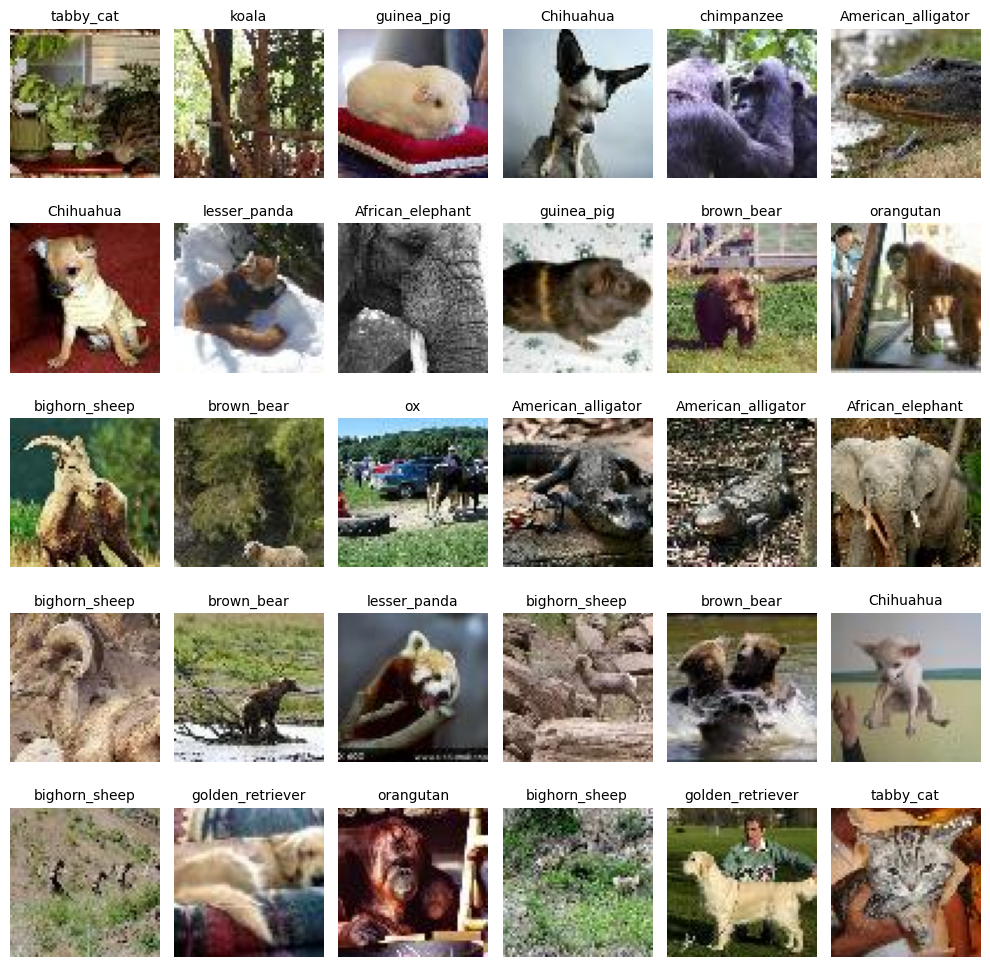

In [ ]:
# Tiny ImageNet Animals に含まれる画像とラベルのペアを表示
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random

# データセットから画像とラベルのペアを表示
def show_sample_images(data_dir="./data/tiny-imagenet-animals/train", num_images=30):
    """
    Args:
        data_dir (str): データディレクトリのパス
        num_images (int): 表示する画像数
    """
    data_path = Path(data_dir)

    if not data_path.exists():
        print(f"Directory not found: {data_path}")
        return

    # 全画像パスとラベルを収集
    image_paths = []
    labels = []

    for class_dir in data_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            # 画像ファイルを検索
            for img_file in class_dir.glob('*.JPEG'):
                image_paths.append(img_file)
                labels.append(class_name)
            for img_file in class_dir.glob('*.jpg'):
                image_paths.append(img_file)
                labels.append(class_name)

    if not image_paths:
        print("No images found")
        return

    # ランダムサンプリング
    indices = random.sample(range(len(image_paths)), min(num_images, len(image_paths)))

    # グリッドサイズの計算
    cols = 6
    rows = (len(indices) + cols - 1) // cols

    # 表示
    fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows)) #figsize=(15, 2.5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        row = i // cols
        col = i % cols

        try:
            # 画像読み込み ＆ 表示
            img = Image.open(image_paths[idx]).convert('RGB')
            axes[row, col].imshow(img)
            axes[row, col].set_title(labels[idx], fontsize=10)
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[row, col].set_title(labels[idx], fontsize=10)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images()

---
## Tiny ImageNet Animals 用のシンプルなCNN実装

### 必要なライブラリのインポート

In [ ]:
# 必要なライブラリのインポート
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from tqdm import tqdm

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Tiny ImageNet Animals 用のカスタム Dataset

In [ ]:
# Tiny ImageNet Animal データセット用のカスタムDataset
class AnimalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): データディレクトリのパス
            transform: 画像変換
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        # クラス名を取得
        class_dirs = sorted([d for d in self.data_dir.iterdir() if d.is_dir()])
        self.class_names = [d.name for d in class_dirs]
        self.num_classes = len(self.class_names)

        # 画像パスとラベルを収集
        for class_idx, class_dir in enumerate(class_dirs):
            class_name = class_dir.name
            image_files = list(class_dir.glob('*.JPEG')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))

            for image_path in image_files:
                self.images.append(str(image_path))
                self.labels.append(class_idx)

        print(f"Total images: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # 画像読み込み
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

### データローダーの作成

In [ ]:
# データローダーの作成
def create_data_loaders(train_dir, test_dir, batch_size=32, img_size=64):
    """
    Args:
        train_dir (str): 訓練データディレクトリ
        test_dir (str): テストデータディレクトリ
        batch_size (int): バッチサイズ
        img_size (int): 画像サイズ

    Returns:
        train_loader, test_loader, num_classes, class_names
    """
    # 画像変換（リサイズ ＆ 正規化のみ）
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # 訓練用データセット作成
    train_dataset = AnimalDataset(train_dir, transform=transform)

    # 検証用データセットの作成
    test_dataset = AnimalDataset(test_dir, transform=transform)

    # データローダー作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2)

    return train_loader, test_loader, train_dataset.num_classes, train_dataset.class_names

### CNN モデルの定義

In [ ]:
# シンプルな CNN モデル
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        '''
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        '''

        # プーリング層
        self.pool = nn.MaxPool2d(2, 2)

        # 全結合層
        self.fc1 = nn.Linear(32*16*16, 512)  # 64x64 -> 4x4 after 4 pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # ドロップアウト
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # 畳み込み層 + ReLU + プーリング
        x = self.pool(F.relu(self.conv1(x)))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 32x32 -> 16x16
        '''
        x = self.pool(F.relu(self.conv1(x)))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv3(x)))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv4(x)))  # 8x8 -> 4x4
        '''

        # 平坦化
        x = x.view(-1, 32 * 16 * 16)

        # 全結合層
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

### モデルの訓練

Total images: 8000
Total images: 800
Number of classes: 16
Training batches: 500
Test batches: 50

Model created with 4335344 parameters

Model Structure:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Starting training for 20 epochs...
--------------------------------------------------


100%|██████████| 500/500 [00:19<00:00, 26.29it/s]


Epoch [1/20] (19.6s)  Train Loss: 2.6718, Train Acc: 12.11%  Test Loss: 2.5413, Val Acc: 18.88%


100%|██████████| 500/500 [00:24<00:00, 20.37it/s]


Epoch [2/20] (25.2s)  Train Loss: 2.3761, Train Acc: 25.24%  Test Loss: 2.2864, Val Acc: 28.50%


100%|██████████| 500/500 [00:24<00:00, 20.03it/s]


Epoch [3/20] (25.6s)  Train Loss: 2.1080, Train Acc: 34.00%  Test Loss: 2.2268, Val Acc: 32.62%


100%|██████████| 500/500 [00:25<00:00, 19.95it/s]


Epoch [4/20] (25.7s)  Train Loss: 1.7963, Train Acc: 42.86%  Test Loss: 2.3487, Val Acc: 31.62%


100%|██████████| 500/500 [00:24<00:00, 20.58it/s]


Epoch [5/20] (24.9s)  Train Loss: 1.3914, Train Acc: 55.39%  Test Loss: 2.5257, Val Acc: 31.62%


100%|██████████| 500/500 [00:24<00:00, 20.27it/s]


Epoch [6/20] (25.3s)  Train Loss: 0.9688, Train Acc: 69.34%  Test Loss: 2.6982, Val Acc: 30.38%


100%|██████████| 500/500 [00:24<00:00, 20.76it/s]


Epoch [7/20] (24.7s)  Train Loss: 0.6737, Train Acc: 78.45%  Test Loss: 2.9081, Val Acc: 31.88%


100%|██████████| 500/500 [00:24<00:00, 20.77it/s]


Epoch [8/20] (24.7s)  Train Loss: 0.4687, Train Acc: 85.05%  Test Loss: 3.2333, Val Acc: 31.62%


100%|██████████| 500/500 [00:24<00:00, 20.70it/s]


Epoch [9/20] (24.9s)  Train Loss: 0.3572, Train Acc: 88.96%  Test Loss: 3.7261, Val Acc: 32.38%


100%|██████████| 500/500 [00:24<00:00, 20.39it/s]


Epoch [10/20] (25.2s)  Train Loss: 0.3109, Train Acc: 90.30%  Test Loss: 3.8570, Val Acc: 30.00%


100%|██████████| 500/500 [00:24<00:00, 20.14it/s]


Epoch [11/20] (25.5s)  Train Loss: 0.2594, Train Acc: 92.25%  Test Loss: 4.0042, Val Acc: 27.62%


100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


Epoch [12/20] (25.9s)  Train Loss: 0.2371, Train Acc: 92.58%  Test Loss: 4.1403, Val Acc: 31.38%


100%|██████████| 500/500 [00:24<00:00, 20.18it/s]


Epoch [13/20] (25.5s)  Train Loss: 0.2049, Train Acc: 94.00%  Test Loss: 3.8813, Val Acc: 29.62%


100%|██████████| 500/500 [00:24<00:00, 20.68it/s]


Epoch [14/20] (24.8s)  Train Loss: 0.1899, Train Acc: 94.30%  Test Loss: 4.6150, Val Acc: 29.12%


100%|██████████| 500/500 [00:24<00:00, 20.20it/s]


Epoch [15/20] (25.4s)  Train Loss: 0.1956, Train Acc: 94.12%  Test Loss: 4.3114, Val Acc: 28.00%


100%|██████████| 500/500 [00:24<00:00, 20.78it/s]


Epoch [16/20] (24.7s)  Train Loss: 0.1991, Train Acc: 93.85%  Test Loss: 4.4078, Val Acc: 27.38%


100%|██████████| 500/500 [00:24<00:00, 20.61it/s]


Epoch [17/20] (25.0s)  Train Loss: 0.1940, Train Acc: 94.26%  Test Loss: 4.3375, Val Acc: 29.50%


100%|██████████| 500/500 [00:24<00:00, 20.60it/s]


Epoch [18/20] (25.0s)  Train Loss: 0.1641, Train Acc: 95.36%  Test Loss: 4.4558, Val Acc: 29.12%


100%|██████████| 500/500 [00:24<00:00, 20.59it/s]


Epoch [19/20] (24.9s)  Train Loss: 0.1505, Train Acc: 95.69%  Test Loss: 4.2879, Val Acc: 27.25%


100%|██████████| 500/500 [00:24<00:00, 20.36it/s]


Epoch [20/20] (25.2s)  Train Loss: 0.1475, Train Acc: 95.53%  Test Loss: 4.8791, Val Acc: 29.25%
Training completed!
Training history saved: training_history.png


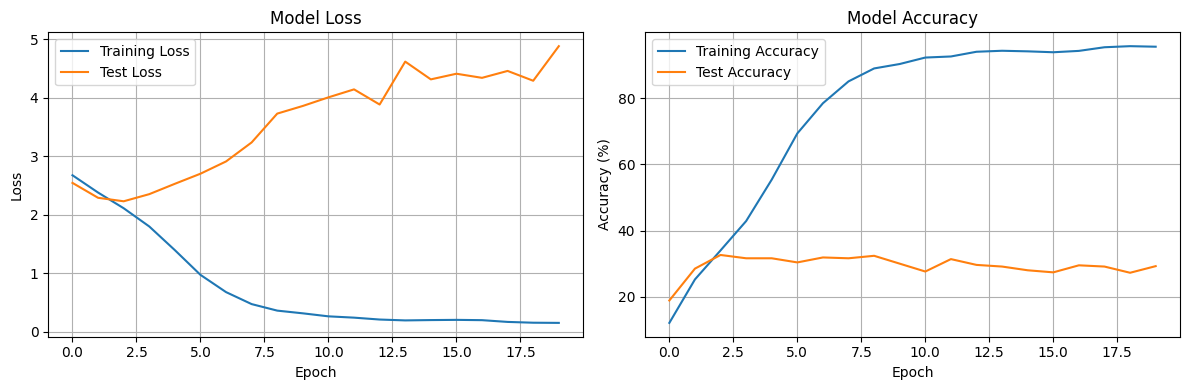

In [ ]:
# モデルの訓練
def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001):
    """
    Args:
        model: PyTorchモデル
        train_loader: 訓練データローダー
        test_loader: テストデータローダー
        num_epochs: エポック数
        learning_rate: 学習率

    Returns:
        training_history: 訓練履歴
    """
    # 損失関数と最適化手法
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 訓練履歴保存用
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 50)

    for epoch in range(num_epochs):
        start_time = time.time()

        # === 訓練フェーズ ===
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for (images, labels) in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # 勾配をゼロにリセット
            optimizer.zero_grad()

            # 順伝播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 逆伝播
            loss.backward()
            optimizer.step()

            # 統計情報更新
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # === 検証フェーズ ===
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # エポック結果の計算
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * test_correct / test_total

        # 履歴に保存
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # 結果表示
        epoch_time = time.time() - start_time

        message = (f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s)'
                   f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%'
                   f'  Test Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%'
        )
        print(message)

    print("Training completed!")
    return history

def plot_training_history(history, save_path=None):
    """
    訓練履歴のプロット

    Args:
        history: 訓練履歴
        save_path (str): 保存パス
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 損失のプロット
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 正解率のプロット
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['test_acc'], label='Test Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history saved: {save_path}")

    plt.show()

# ========== ここから学習が始まる ==========
# ハイパーパラメータ
batch_size = 16
num_epochs = 20
learning_rate = 0.001
img_size = 64

# データパス
train_dir = "./data/tiny-imagenet-animals/train"
test_dir = "./data/tiny-imagenet-animals/val"

# データローダー作成
train_loader, test_loader, num_classes, class_names = create_data_loaders(
    train_dir, test_dir, batch_size, img_size
)

print(f"Number of classes: {num_classes}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# モデル作成
model = SimpleCNN(num_classes).to(device)
print(f"\nModel created with {sum(p.numel() for p in model.parameters())} parameters")
print("\nModel Structure:")
print(model)

# モデル訓練
history = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

# 訓練履歴のプロット
plot_training_history(history, 'training_history.png')


### モデルの評価


In [ ]:
# モデルの評価
def evaluate_model(model, test_loader, class_names):
    """
    Args:
        model: 訓練済みモデル
        test_loader: テストデータローダー
        class_names: クラス名リスト
    """
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # クラス別正解率の計算
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    # 全体の正解率
    overall_accuracy = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_accuracy:.2f}%')

    # クラス別正解率
    print(f'\nClass-wise Accuracy:')
    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'  {class_name}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'  {class_name}: No test samples')

# モデル評価
evaluate_model(model, test_loader, class_names)


Overall Test Accuracy: 29.25%

Class-wise Accuracy:
  African_elephant: 26.00% (13/50)
  American_alligator: 42.00% (21/50)
  Chihuahua: 10.00% (5/50)
  bighorn_sheep: 30.00% (15/50)
  brown_bear: 36.00% (18/50)
  chimpanzee: 60.00% (30/50)
  cougar: 14.00% (7/50)
  golden_retriever: 38.00% (19/50)
  guinea_pig: 34.00% (17/50)
  hog: 16.00% (8/50)
  koala: 40.00% (20/50)
  lesser_panda: 36.00% (18/50)
  lion: 26.00% (13/50)
  orangutan: 12.00% (6/50)
  ox: 22.00% (11/50)
  tabby_cat: 26.00% (13/50)


### (参考) サンプル画像の予測
val_loader から一部のデータを取り出して，予測を行う。

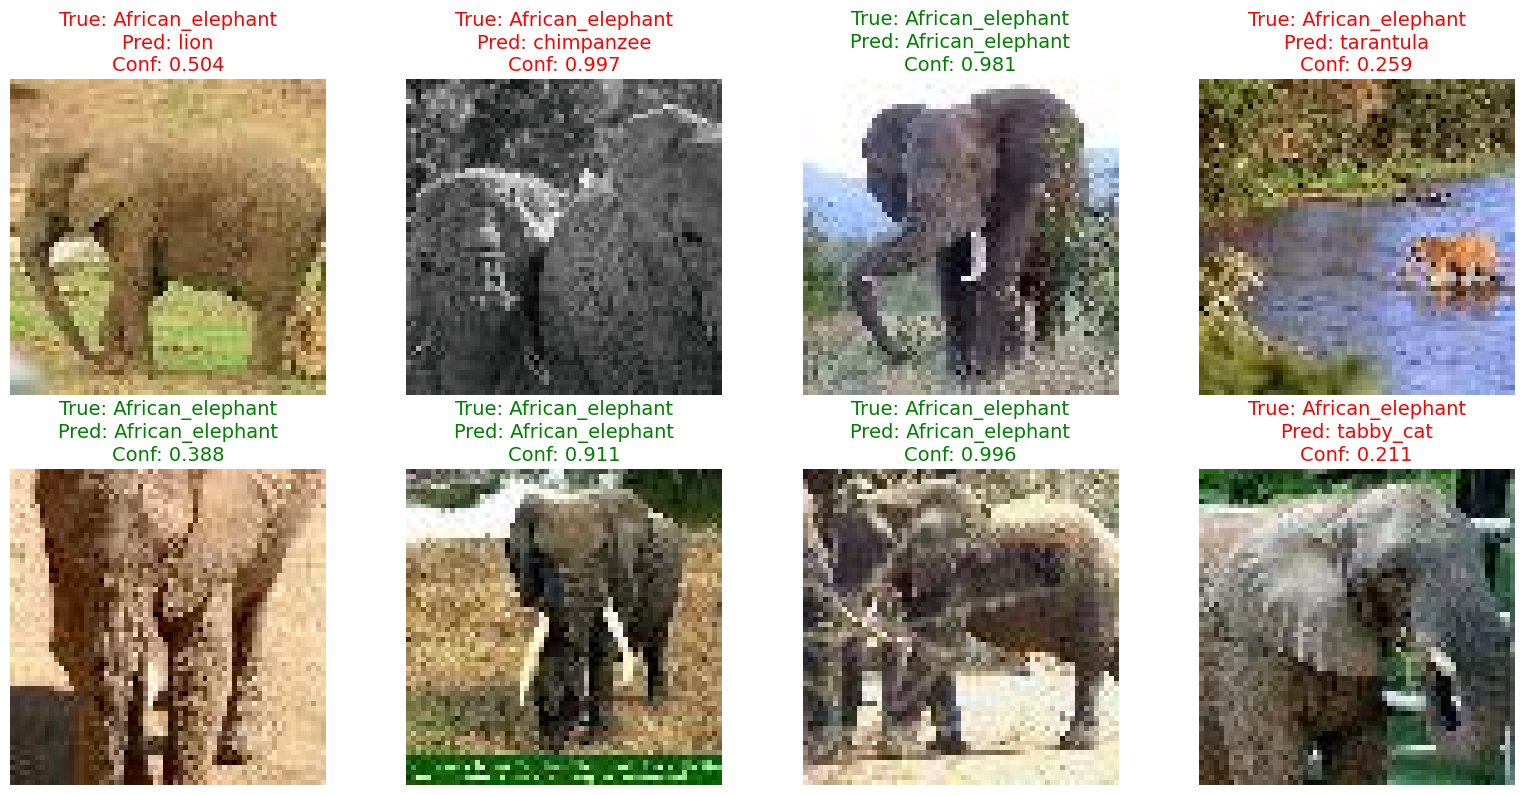

In [ ]:
def predict_sample_images(model, test_loader, class_names, num_samples=8):
    """
    サンプル画像の予測結果表示

    Args:
        model: 訓練済みモデル
        test_loader: テストデータローダー
        class_names: クラス名リスト
        num_samples (int): 表示サンプル数
    """
    model.eval()

    # サンプル画像を取得
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # 予測実行
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)

    # 正規化を元に戻す
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # 結果表示
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # 画像を正規化前に戻す
        img = images[i].cpu() * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        # 画像表示
        axes[i].imshow(img)

        # ラベル情報
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        confidence = probabilities[i][predicted[i]].item()

        # タイトル設定
        # ラベルは正解ならば緑，不正解ならば赤
        color = 'green' if labels[i] == predicted[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                        color=color, fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# サンプル予測
predict_sample_images(model, test_loader, class_names)